# Convolutional Neural Networks for digit image classification

The popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit image classification dataset contains 60′000 + 10′000 hand- written digits to be classified as a number between 0 and 9.

The sequence of (more and more complex) models defined below will eventually arrive at the one suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Steps

1. Loading and plotting the mnist dataset
2. Setting the sceene for image classification 
3. Defining and evaluating the baseline model 
4. Adding Pooling
5. Adding a CNN Kernel
6. Adding another dense output layer

## Loading and plotting the MNIST dataset

*Imported some modules to set seeds*

In [1]:
import numpy as np
import random
import tensorflow as tf

2024-05-20 08:58:50.327224: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 08:58:50.328527: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 08:58:50.396882: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 08:58:50.645264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 08:58:51.277610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


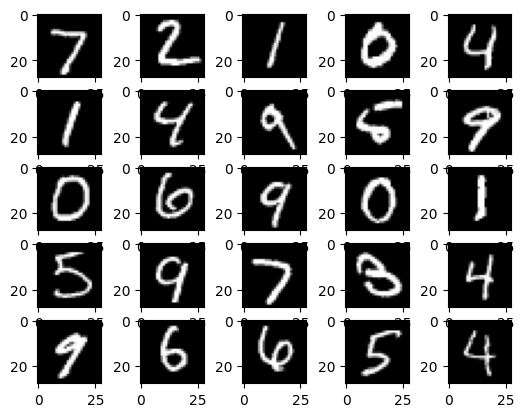

In [3]:
from tensorflow.keras.datasets.mnist import load_data 
from matplotlib import pyplot

set_seeds()
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape)) 
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

## Setting the sceene for image classification

Fix necessary imports.

In [4]:
from numpy import zeros
from numpy import unique
from numpy import argmax
from numpy import asarray
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.metrics import Accuracy

Reshape data to have a single b/w channel.

In [5]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


Determine the number of classes.

In [6]:
n_classes = len(unique(y_train)) 
print("Classes: {0}".format(n_classes))

Classes: 10


Normalize pixel values `int[0..255]` $\rightarrow$ `float32[0..1]`.

In [7]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Function to define the CNN model architecture and compile it with constant surrogate goal function (loss), evaluation metrics, and optimizer. We will vary depth, kernel_width, and pool_stride of the models.

In [8]:
def make_model(depth, kernel_width, pool_stride, add_dense=False, dense_structure=[100]):
    model = Sequential()
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu',input_shape=in_shape))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    if add_dense:
        for size in dense_structure:
            model.add(Dense(size, activation='relu'))
            model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

Define learning parameters for all models.

In [9]:
EPOCHS = 10
BATCH_SIZE = 128
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max', 
    restore_best_weights=True)
it = round(60000/BATCH_SIZE)

It takes {{it}} iterations to finish an epch.

Function to show the history of training.

In [10]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color'] 
    metrics = ['loss', 'accuracy'] 
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(1,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0],label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],color=colors[0], linestyle="--", label='Val') 
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1]) 
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

## Baseline

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=1`, i.e., no effective CNN.

In [11]:
set_seeds()

baseline = make_model(1,1,1)
baseline.summary()

/media/home/ngundermann/workspace/DML_notebooks/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-20 08:58:53.026839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 08:58:53.046702: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/inst

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,852 (30.67 KB)

 Trainable params: 7,852 (30.67 KB)

 Non-trainable params: 0 (0.00 B)

Note that the kernel has one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the CNN and the pooling layers are equal to their inputs.

We train the baseline model.

In [12]:
baseline_history = baseline.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7030 - loss: 1.0291 - val_accuracy: 0.9084 - val_loss: 0.3335
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.3351 - val_accuracy: 0.9178 - val_loss: 0.2901
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9146 - loss: 0.2972 - val_accuracy: 0.9227 - val_loss: 0.2771
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9206 - loss: 0.2821 - val_accuracy: 0.9249 - val_loss: 0.2718
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9236 - loss: 0.2736 - val_accuracy: 0.9255 - val_loss: 0.2692
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9260 - loss: 0.2680 - val_accuracy: 0.9258 - val_loss: 0.2678
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9273 - loss: 0.2638 - val_accuracy: 0.9259 - val_loss: 0.2672
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9285 - loss: 0.2605 - val_accuracy: 0.

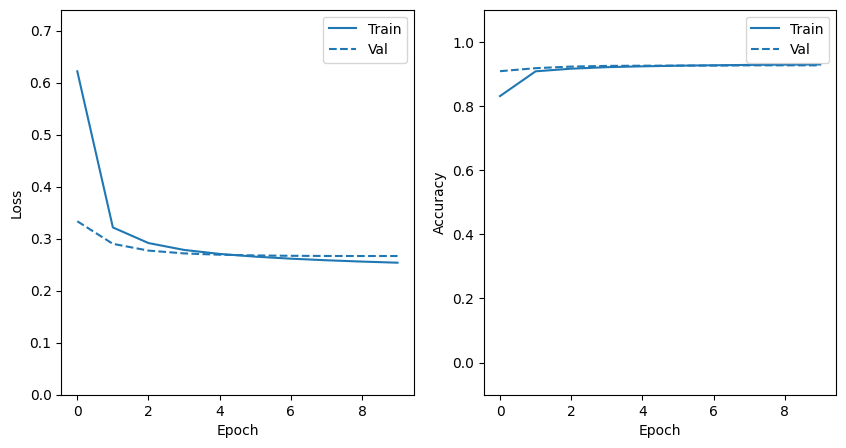

In [13]:
plot_metrics(baseline_history)

We do not observe effective learning. We evaluate the trained model.

*In my case, the learning was indeed effective*

In [14]:
loss, acc = baseline.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.927


Use the model to make a prediction.

In [15]:
xx = x_test[9]
xxx = asarray([xx])
yhat = baseline.predict(xxx)
argmax(yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


9

In [16]:
def print_res(model): 
    err = 0
    i_range = 10
    ys = zeros(i_range * i_range) 
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m' 
    for i in range(i_range):
        for j in range(i_range):
            idx = i*i_range+j
            image = x_test[idx]
            yhat = model.predict(asarray([image]))
            ys[idx] = argmax(yhat) 
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range): 
        for j in range(i_range):
            idx = i*i_range+j; 
            y = y_test[idx] 
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                err = err + 1
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '') 
        print()
    return err

In [17]:
err = print_res(baseline)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [18]:
err

4

*The classic dense layer does perform good alone due to the fact that there are actually 7852 learnable parameters, i.e. 2 from the convolutional layer and 7850 from the dense layer. So a network with one hidden layer with the same size than the input layer would be sufficient either way. The target, therefore, is to reduce the parameters in the model while increasing the accuracy.*

*Baseline parameters:*
- *Model Complexity (Paramereters) = 7852*
- *Accuracy: 0.927*
- *Test error in first 100 images: 4*

## Adding Pooling

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=2`, i.e., no effective CNN and we even squeeze the image size, which would result in a less complex model.

In [19]:
set_seeds()
model1 = make_model(1,1,2, False)
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,972 (7.70 KB)

 Trainable params: 1,972 (7.70 KB)

 Non-trainable params: 0 (0.00 B)

The kernel has still one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the pooling layers is one quater (half in each dimension) of the CNN in- and output. The dense layer got 1970 weights.

We train the first CNN model.

In [20]:
model1_history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5493 - loss: 1.4949 - val_accuracy: 0.8781 - val_loss: 0.4755
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8745 - loss: 0.4512 - val_accuracy: 0.8995 - val_loss: 0.3583
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8942 - loss: 0.3639 - val_accuracy: 0.9061 - val_loss: 0.3242
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9020 - loss: 0.3342 - val_accuracy: 0.9105 - val_loss: 0.3084
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.3190 - val_accuracy: 0.9132 - val_loss: 0.2993
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9093 - loss: 0.3096 - val_accuracy: 0.9145 - val_loss: 0.2935
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9120 - loss: 0.3032 - val_accuracy: 0.9159 - val_loss: 0.2896
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9129 - loss: 0.2986 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 10. So I ran the training again. After I plotted the training history.*

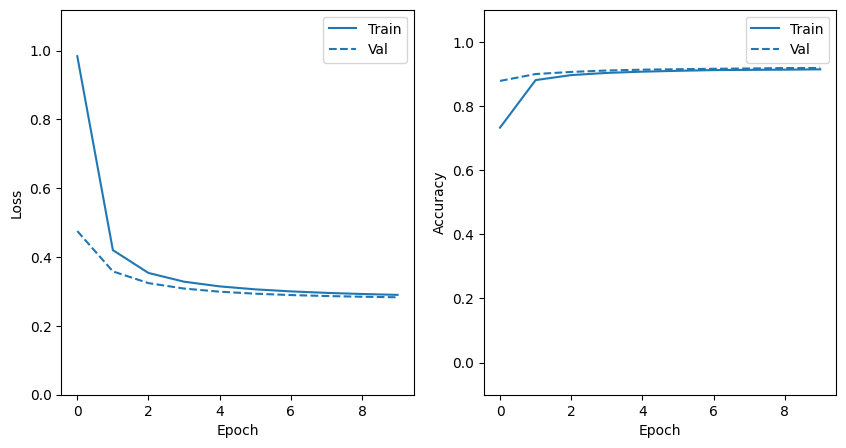

In [21]:
plot_metrics(model1_history)

In [22]:
set_seeds()
model1 = make_model(1,1,2, False)
model1_history = model1.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5493 - loss: 1.4949 - val_accuracy: 0.8781 - val_loss: 0.4755
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8745 - loss: 0.4512 - val_accuracy: 0.8995 - val_loss: 0.3583
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8942 - loss: 0.3639 - val_accuracy: 0.9061 - val_loss: 0.3242
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9020 - loss: 0.3342 - val_accuracy: 0.9105 - val_loss: 0.3084
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.3190 - val_accuracy: 0.9132 - val_loss: 0.2993
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9093 - loss: 0.3096 - val_accuracy: 0.9145 - val_loss: 0.2935
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9120 - loss: 0.3032 - val_accuracy: 0.9159 - val_loss: 0.2896
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9129 - loss: 0.2986 - val_accuracy: 0.

We evaluate the trained model.

In [23]:
loss, acc = model1.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.918


This cannot be any better. Use the model to make a prediction.

In [24]:
err = print_res(model1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

In [25]:
err

6

*The accuracy decreased as well as the number of parameters. However, the decrease in accuracy was about 0.09 and the reduce in the number of parameters was (7582 - 1972 = ) 5610, resulting in a much smaller model.*


*Model 1 Parameters:*
- *Model Complexity (Paramereters) = 1972*
- *Accuracy: 0.918*
- *Test error in first 100 images: 6*


## Adding a CNN Kernel

*Because we might assume, that evaluating more pixels together could compensate for the pool stride that might have caused the decrease of accuracy in the previous model. Additionally, we would decrease the complexity of the model one more time.*

In [26]:
set_seeds()
model2 = make_model(1,3,2)
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 169)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,710 (6.68 KB)

 Trainable params: 1,710 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

The kernel has still 3 × 3 weights and one bias, i.e., `Param = 10` for the CNN layer. No padding is applied, so the CNN layer ‘eats’ one pixel at the corners, i.e., its output shape is `(26, 26, 1)`. The output of the pooling layers is one quater (half in x and y dimension) of the CNN output. Therefore, the weight for the dense layer were reduced to 1700.

We train the first real CNN model.

In [27]:
model2_history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5618 - loss: 1.3862 - val_accuracy: 0.8892 - val_loss: 0.3933
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8871 - loss: 0.3864 - val_accuracy: 0.9074 - val_loss: 0.3248
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9027 - loss: 0.3358 - val_accuracy: 0.9133 - val_loss: 0.3027
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9083 - loss: 0.3160 - val_accuracy: 0.9156 - val_loss: 0.2920
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9117 - loss: 0.3053 - val_accuracy: 0.9173 - val_loss: 0.2858
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9137 - loss: 0.2985 - val_accuracy: 0.9182 - val_loss: 0.2817
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9152 - loss: 0.2938 - val_accuracy: 0.9189 - val_loss: 0.2787
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9161 - loss: 0.2902 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 10. So I ran the training again. After I plotted the training history.*

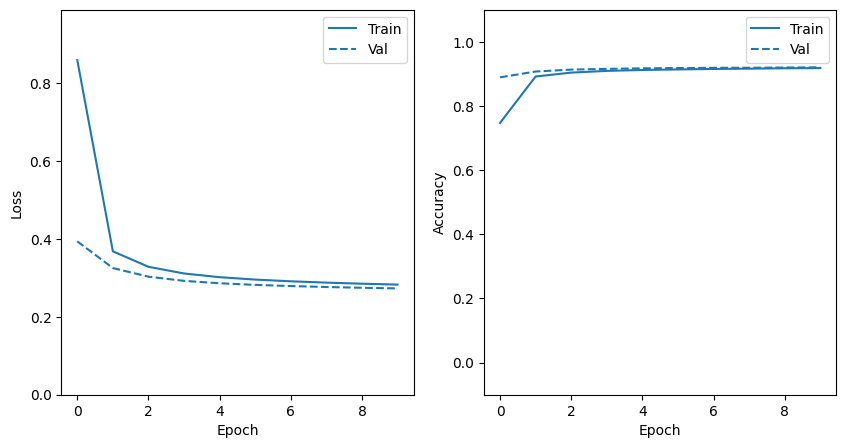

In [28]:
plot_metrics(model2_history)

Now we see effective training. We evaluate the trained model.

*In my case, I saw it in other settings too*

In [29]:
set_seeds()
model2 = make_model(1,3,2)

model2_history = model2.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5618 - loss: 1.3862 - val_accuracy: 0.8892 - val_loss: 0.3933
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8871 - loss: 0.3864 - val_accuracy: 0.9074 - val_loss: 0.3248
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9027 - loss: 0.3358 - val_accuracy: 0.9133 - val_loss: 0.3027
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9083 - loss: 0.3160 - val_accuracy: 0.9156 - val_loss: 0.2920
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9117 - loss: 0.3053 - val_accuracy: 0.9173 - val_loss: 0.2858
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9137 - loss: 0.2985 - val_accuracy: 0.9182 - val_loss: 0.2817
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9152 - loss: 0.2938 - val_accuracy: 0.9189 - val_loss: 0.2787
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9161 - loss: 0.2902 - val_accuracy: 0.

In [30]:
loss, acc = model2.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.920


Use the model to make a prediction.

In [31]:
err = print_res(model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [32]:
err

4

*The accuracy increased a little bit about 0.002 while the complexity on the model decreased again by (1972-1710=) 262 compared to model 1.*

*Model 2 Parameters:*
- *Model Complexity (Paramereters) = 1710*
- *Accuracy: 0.92*
- *Test error in first 100 images: 4*

## Adding Parallel CNN Kernels

We set `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2`. *Because we assume that there are different features that are relevant to classify the images. Thus, we need to add more kernels in order to learn filters capable to detect these features. However, we pay for this with much more weights in the dense layer as well as in the convolution layer.*

In [33]:
set_seeds()
model3 = make_model(32,3,2)
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        54,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

There are 32 kernels has each with 3 × 3 weights and one bias, i.e., `Param = 320` for the CNN layer. As no padding is applied, the CNN layer’s output shape is the same for the x and y dimensions , but it adds depth: `(26, 26, 32)`. The output of the pooling layers is one quater (half in x and y dimension) of the CNN output, but it keeps the depth. *Additionally, the dense layers weights grew to 54090.*

We train the first CNN model.

In [34]:
model3_history = model3.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8311 - loss: 0.6482 - val_accuracy: 0.9596 - val_loss: 0.1408
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9636 - loss: 0.1337 - val_accuracy: 0.9730 - val_loss: 0.0893
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9763 - loss: 0.0879 - val_accuracy: 0.9778 - val_loss: 0.0725
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9812 - loss: 0.0696 - val_accuracy: 0.9790 - val_loss: 0.0654
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9836 - loss: 0.0594 - val_accuracy: 0.9801 - val_loss: 0.0615
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9855 - loss: 0.0524 - val_accuracy: 0.9800 - val_loss: 0.0587
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9868 - loss: 0.0471 - val_accuracy: 0.9810 - val_loss: 0.0568
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.0427 - val_accuracy: 0.

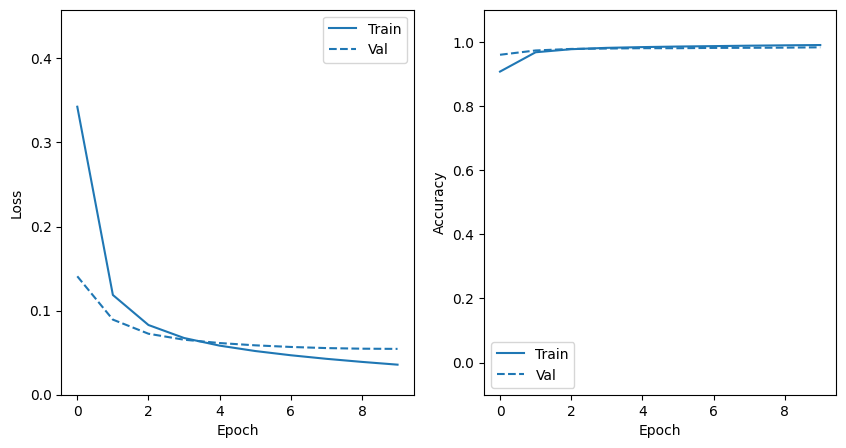

In [35]:
plot_metrics(model3_history)

In [36]:
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.983


In [37]:
err = print_res(model3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

In [38]:
err

3

*Here the accuracy goes up to 0.983 outperform all models trained so far. However, this is also the most complex model with a total parameter size of 54410 parameters.*

*Model 3 parameters:*
- *Model Complexity (Paramereters) = 54410*
- *Accuracy: 0.983*
- *Test error in first 100 images: 3*


## Adding another dense (hidden) layer

*Because we might assume, that the learning can be improved when applying a more complex network after the convolution layer. However, we pay for this one more time with a more complex model.*

In [39]:
set_seeds()
model4 = make_model(32,3,2,True)
model4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

This lets the number of parameters grow to over half a million!
We train this final CNN model.

In [40]:
model4_history = model4.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8085 - loss: 0.6309 - val_accuracy: 0.9715 - val_loss: 0.0883
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9590 - loss: 0.1445 - val_accuracy: 0.9787 - val_loss: 0.0644
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9704 - loss: 0.1011 - val_accuracy: 0.9807 - val_loss: 0.0540
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9749 - loss: 0.0851 - val_accuracy: 0.9828 - val_loss: 0.0489
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9787 - loss: 0.0711 - val_accuracy: 0.9834 - val_loss: 0.0457
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9810 - loss: 0.0629 - val_accuracy: 0.9846 - val_loss: 0.0421
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9824 - loss: 0.0576 - val_accuracy: 0.9861 - val_loss: 0.0407
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9852 - loss: 0.0504 - val_accuracy: 0.

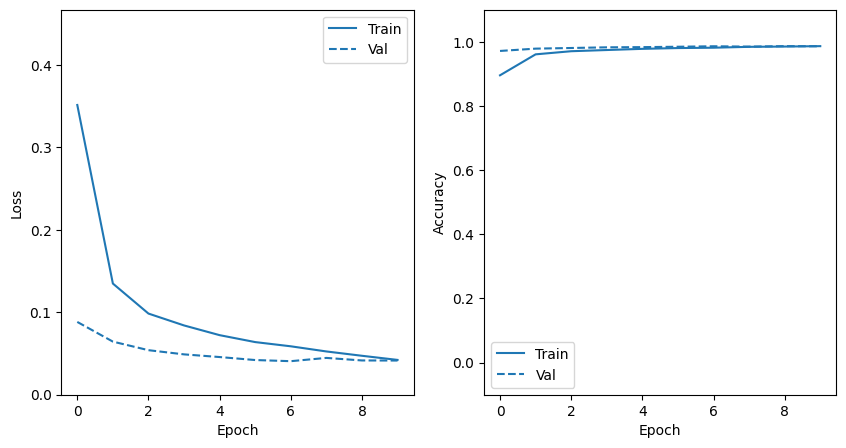

In [41]:
plot_metrics(model4_history)

In [42]:
loss, acc = model4.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.987


In [43]:
err = print_res(model4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

In [44]:
err

2

*Here the accuracy goes up to 0.987 an outperform all models trained so far. However, this is also the most complex model with a total parameter size of 542230 parameters. So we multiplied the number of parameters by 10 while we got an increase in accuracy by only 0.004.*

*Model 4 parameters:*
- *Model Complexity (Paramereters) = 542230*
- *Accuracy: 0.987*
- *Test error in first 100 images: 2*

*Maybe we can reach a similar result with a larger kernel, since relevant features could also be detected on a larger part of the image than a 3x3 tile. Additionally, this would reduce the number of trainable parameters.*

In [45]:
set_seeds()
model5 = make_model(32,9,2,True)
model5.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,734 (1.23 MB)

 Trainable params: 323,734 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

*Here, I tested 32 9x9 kernel with stride = 2, which results in a 20x20 output shape of the convolution layer. Since I added no padding, the cnn neglect 4 pixels at the corners. Hence, the output shape is (20,20,32). However, I think the relevant features can be found in the middle if the images.*

*This setting increases the number of parameters in the convolution layer. However, is decrease the number of parameters in the first dense layer on a much higher scale.*

In [46]:
model5_history = model5.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8106 - loss: 0.6087 - val_accuracy: 0.9783 - val_loss: 0.0678
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9645 - loss: 0.1269 - val_accuracy: 0.9833 - val_loss: 0.0478
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9752 - loss: 0.0863 - val_accuracy: 0.9865 - val_loss: 0.0395
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9779 - loss: 0.0721 - val_accuracy: 0.9874 - val_loss: 0.0357
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9824 - loss: 0.0605 - val_accuracy: 0.9886 - val_loss: 0.0331
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9856 - loss: 0.0500 - val_accuracy: 0.9890 - val_loss: 0.0332
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9860 - loss: 0.0454 - val_accuracy: 0.9892 - val_loss: 0.0316
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9861 - loss: 0.0426 - val_accuracy: 0.

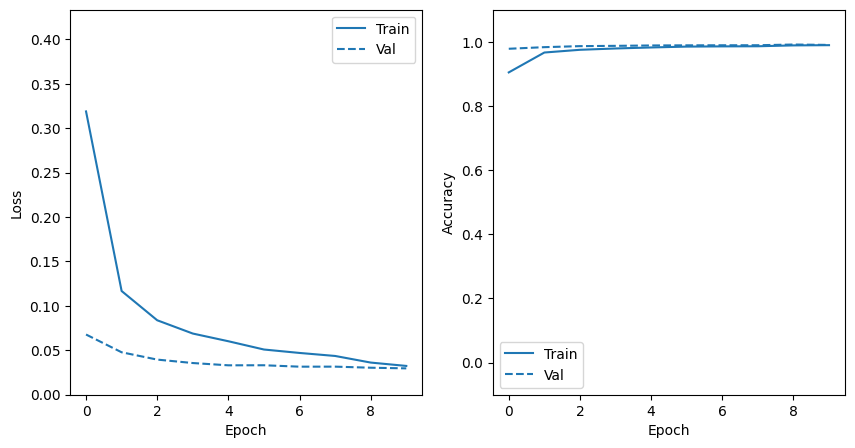

In [47]:
plot_metrics(model5_history)

In [48]:
loss, acc = model5.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.992


In [49]:
err = print_res(model5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

In [50]:
err

0

*Here, we reached both, an increase in accuracy to 0.992 and a decrease in model complexity to 323734 parameters. Hence, this is the best model so far.*

*Model 5 parameters:*
- *Model Complexity (Paramereters) = 323734*
- *Accuracy: 0.992*
- *Test error in first 100 images: 0*

*Since this worked great, we should try a larger kernel again, because we might assume that even a 9x9 kernel is to detailed.* 

In [51]:
set_seeds()
model6 = make_model(32,11,2,True)
model6.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 32)     │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │       259,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,214 (1.01 MB)

 Trainable params: 264,214 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

*This one more time reduced the model complexity. However, the CNN eats more of the corner pixels, i.e. 4 in each corner, and ,thus, focues more on the center of the image.  Let's check the training.*

In [52]:
model6_history = model6.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8090 - loss: 0.6164 - val_accuracy: 0.9784 - val_loss: 0.0688
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9626 - loss: 0.1280 - val_accuracy: 0.9845 - val_loss: 0.0478
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9734 - loss: 0.0870 - val_accuracy: 0.9878 - val_loss: 0.0376
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9785 - loss: 0.0709 - val_accuracy: 0.9879 - val_loss: 0.0356
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9808 - loss: 0.0624 - val_accuracy: 0.9884 - val_loss: 0.0346
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9844 - loss: 0.0523 - val_accuracy: 0.9894 - val_loss: 0.0304
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9859 - loss: 0.0491 - val_accuracy: 0.9903 - val_loss: 0.0300
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9867 - loss: 0.0436 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 10. So I ran the training again. After I plotted the training history.*

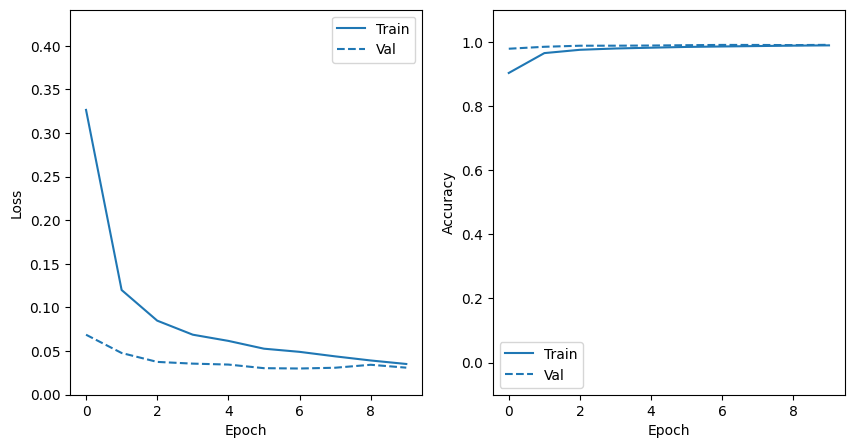

In [53]:
plot_metrics(model6_history)

In [54]:
set_seeds()
model6 = make_model(32,11,2,True)

model6_history = model6.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8090 - loss: 0.6164 - val_accuracy: 0.9784 - val_loss: 0.0688
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9626 - loss: 0.1280 - val_accuracy: 0.9845 - val_loss: 0.0478
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9734 - loss: 0.0870 - val_accuracy: 0.9878 - val_loss: 0.0376
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9785 - loss: 0.0709 - val_accuracy: 0.9879 - val_loss: 0.0356
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9808 - loss: 0.0624 - val_accuracy: 0.9884 - val_loss: 0.0346
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9844 - loss: 0.0523 - val_accuracy: 0.9894 - val_loss: 0.0304
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9859 - loss: 0.0491 - val_accuracy: 0.9903 - val_loss: 0.0300
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9867 - loss: 0.0436 - val_accuracy: 0.

In [55]:
loss, acc = model6.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.991


In [56]:
err = print_res(model6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

In [57]:
err

0

*So, in terms of accuracy, this went into the wrong direction (a little bit). However, we decrease the models complexity. But since there are other approaches to increase model complexity, I will stick to the 9x9 kernel from the previous model.*

*Model 6 parameters:*
- *Model Complexity (Paramereters) = 264214*
- *Accuracy: 0.991*
- *Test error in first 100 images: 0*

*Now, let's reduce the number of kernels, in order to decrease the number of parameters a bit more. This is because I assume, that there are less than 32 features necessary to do the classification.*

In [58]:
set_seeds()
model7 = make_model(16,9,2,True)
model7.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 16)     │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,422 (634.46 KB)

 Trainable params: 162,422 (634.46 KB)

 Non-trainable params: 0 (0.00 B)

*Here, I used 16 kernels instead of 32, which approximately halfes reduces the number of parameters.*

In [59]:
model7_history = model7.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7845 - loss: 0.7012 - val_accuracy: 0.9748 - val_loss: 0.0831
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9606 - loss: 0.1369 - val_accuracy: 0.9822 - val_loss: 0.0553
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9718 - loss: 0.0958 - val_accuracy: 0.9850 - val_loss: 0.0452
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9759 - loss: 0.0814 - val_accuracy: 0.9859 - val_loss: 0.0418
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9804 - loss: 0.0665 - val_accuracy: 0.9879 - val_loss: 0.0361
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9829 - loss: 0.0577 - val_accuracy: 0.9882 - val_loss: 0.0346
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9837 - loss: 0.0537 - val_accuracy: 0.9878 - val_loss: 0.0371
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9861 - loss: 0.0461 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 9. So I ran the training again. After I plotted the training history.*

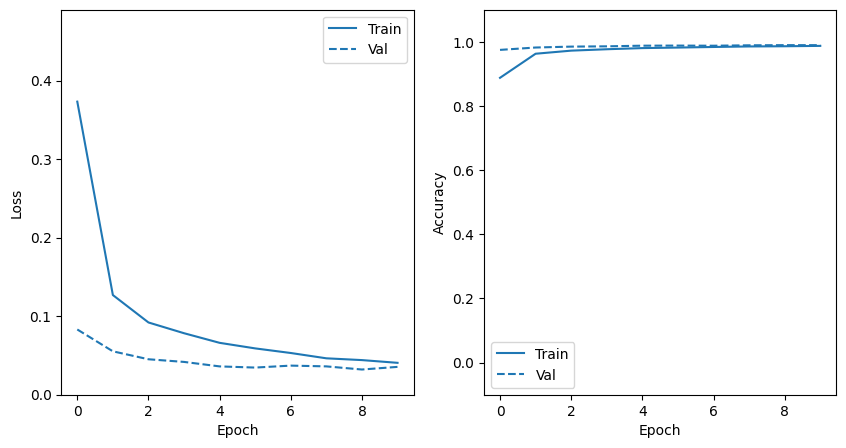

In [60]:
plot_metrics(model7_history)

In [61]:
set_seeds()
model7 = make_model(16,9,2,True)

model7_history = model7.fit(
    x_train,
    y_train,
    epochs=9,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7845 - loss: 0.7012 - val_accuracy: 0.9748 - val_loss: 0.0831
Epoch 2/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9606 - loss: 0.1369 - val_accuracy: 0.9822 - val_loss: 0.0553
Epoch 3/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9718 - loss: 0.0958 - val_accuracy: 0.9850 - val_loss: 0.0452
Epoch 4/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9759 - loss: 0.0814 - val_accuracy: 0.9859 - val_loss: 0.0418
Epoch 5/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9804 - loss: 0.0665 - val_accuracy: 0.9879 - val_loss: 0.0361
Epoch 6/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9829 - loss: 0.0577 - val_accuracy: 0.9882 - val_loss: 0.0346
Epoch 7/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9837 - loss: 0.0537 - val_accuracy: 0.9878 - val_loss: 0.0371
Epoch 8/9
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9861 - loss: 0.0461 - val_accuracy: 0.9891 - v

In [62]:
loss, acc = model7.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.990


In [63]:
err = print_res(model7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

In [64]:
err

0

*So one more time, in terms of accuracy, this went into the wrong direction. However, we decrease the models complexity much more than in the previous model. But since there are other approaches to increase model complexity, I will stick to the 32 kernels from the model 5.*

*Model 7 parameters:*
- *Model Complexity (Paramereters) = 162422*
- *Accuracy: 0.990*
- *Test error in first 100 images: 0*

*Let's try to add another convolution layer, because I assume that the features extracted from the first convolution layer can be aggregated one more time to reduce the parameters for the dense layers. However, I will use a smaller kernel, because I have to work the with output of the max pooling layer of 10x10*

In [65]:
set_seeds()
model8 = Sequential()
model8.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model8.add(MaxPool2D((2, 2)))
model8.add(Conv2D(32, (3,3), activation='relu'))
model8.add(MaxPool2D((1, 1)))
model8.add(Flatten())
model8.add(Dense(100, activation='relu'))
model8.add(Dropout(0.5))
model8.add(Dense(n_classes, activation='softmax')) 
model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model8.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,782 (850.71 KB)

 Trainable params: 217,782 (850.71 KB)

 Non-trainable params: 0 (0.00 B)

*The second convolution layer eats again 1 corner pixels from the output of the first convolution layer. Because of the stride of 2 in the first pooling layer, the cnn will eat effectively 6 corner pixels of the image. (May a little bit to many.)*

In [66]:
model8_history = model8.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8053 - loss: 0.6215 - val_accuracy: 0.9795 - val_loss: 0.0628
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9662 - loss: 0.1177 - val_accuracy: 0.9866 - val_loss: 0.0409
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9768 - loss: 0.0810 - val_accuracy: 0.9831 - val_loss: 0.0510
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9809 - loss: 0.0684 - val_accuracy: 0.9896 - val_loss: 0.0335
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9850 - loss: 0.0555 - val_accuracy: 0.9912 - val_loss: 0.0277
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9858 - loss: 0.0481 - val_accuracy: 0.9916 - val_loss: 0.0263
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9879 - loss: 0.0409 - val_accuracy: 0.9924 - val_loss: 0.0248
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9891 - loss: 0.0359 - val_accuracy: 0.

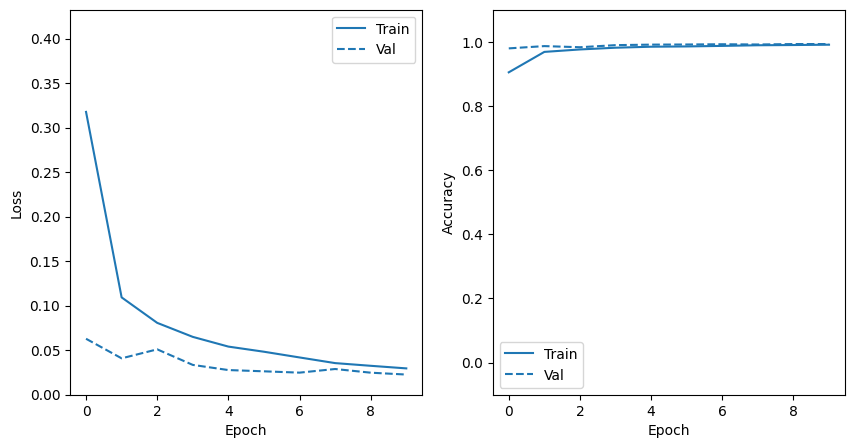

In [67]:
plot_metrics(model8_history)

In [68]:
loss, acc = model8.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.993


In [69]:
err = print_res(model8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [70]:
err

0

*This resulted in the best accuracy we have seen so far. Additionally, the models complexity is lower than our current benchmark model 5.*

*Model 8 parameters:*
- *Model Complexity (Paramereters) = 217782*
- *Accuracy: 0.993*
- *Test error in first 100 images: 0*

*Now, let's try to add stride to the second convolution layer, because I assume that the output doesn't have to be that detailed in order to do the classification.*

In [71]:
set_seeds()
model9 = Sequential()
model9.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model9.add(MaxPool2D((2, 2)))
model9.add(Conv2D(32, (3,3), activation='relu'))
model9.add(MaxPool2D((2, 2)))
model9.add(Flatten())
model9.add(Dense(100, activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(n_classes, activation='softmax')) 
model9.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model9.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,182 (250.71 KB)

 Trainable params: 64,182 (250.71 KB)

 Non-trainable params: 0 (0.00 B)

*You see, we have decrease the models complexity enourmos.*

In [72]:
model9_history = model9.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7644 - loss: 0.7453 - val_accuracy: 0.9748 - val_loss: 0.0759
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9631 - loss: 0.1295 - val_accuracy: 0.9850 - val_loss: 0.0450
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9729 - loss: 0.0900 - val_accuracy: 0.9865 - val_loss: 0.0395
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9779 - loss: 0.0768 - val_accuracy: 0.9885 - val_loss: 0.0332
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9821 - loss: 0.0630 - val_accuracy: 0.9885 - val_loss: 0.0320
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9846 - loss: 0.0516 - val_accuracy: 0.9909 - val_loss: 0.0256
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9873 - loss: 0.0435 - val_accuracy: 0.9921 - val_loss: 0.0237
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9871 - loss: 0.0423 - val_accuracy: 0.

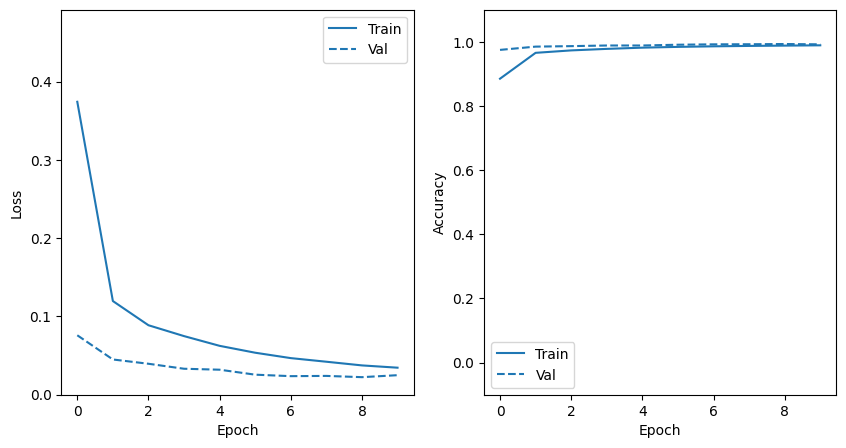

In [73]:
plot_metrics(model9_history)

In [74]:
loss, acc = model9.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.993


In [75]:
err = print_res(model9)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

In [76]:
err

1

*That worked too. We sticked to the level of accuracy, but decreased the models complexity one more time.*

*Model 9 parameters:*
- *Model Complexity (Paramereters) = 64182*
- *Accuracy: 0.993*
- *Test error in first 100 images: 0*

*Let's add another convolution layer, because I think the features can be aggregated once more before classification. This would also result in a further reduction of the number of parameters*

In [77]:
set_seeds()
model10 = Sequential()
model10.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model10.add(MaxPool2D((2, 2)))
model10.add(Conv2D(32, (3,3), activation='relu')) 
model10.add(MaxPool2D((2,2)))
model10.add(Conv2D(32, (3,3), activation='relu'))
model10.add(MaxPool2D((1,1)))
model10.add(Flatten())
model10.add(Dense(100, activation='relu'))
model10.add(Dropout(0.5))
model10.add(Dense(n_classes, activation='softmax')) 
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model10.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 2, 2, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,030 (136.84 KB)

 Trainable params: 35,030 (136.84 KB)

 Non-trainable params: 0 (0.00 B)

*I added a third conv layer with a 32 3x3 kernels, which would result in more corner pixels to be eaten by the cnn and, thus, let the cnn focus even more on the center of the image. After the conv layer, I added a pseudo Pooling layer with a stride of 1.*

In [78]:
model10_history = model10.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7192 - loss: 0.8423 - val_accuracy: 0.9714 - val_loss: 0.0900
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9603 - loss: 0.1380 - val_accuracy: 0.9819 - val_loss: 0.0534
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9723 - loss: 0.0963 - val_accuracy: 0.9858 - val_loss: 0.0419
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9779 - loss: 0.0777 - val_accuracy: 0.9863 - val_loss: 0.0375
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9818 - loss: 0.0631 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9855 - loss: 0.0512 - val_accuracy: 0.9913 - val_loss: 0.0267
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9863 - loss: 0.0478 - val_accuracy: 0.9931 - val_loss: 0.0230
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9878 - loss: 0.0401 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 7. So I ran the training again. After I plotted the training history.*

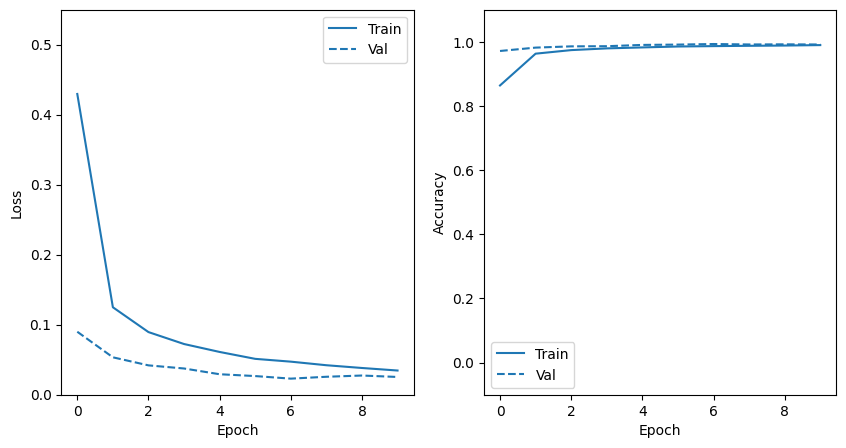

In [79]:
plot_metrics(model10_history)

In [80]:
set_seeds()
model10 = Sequential()
model10.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model10.add(MaxPool2D((2, 2)))
model10.add(Conv2D(32, (3,3), activation='relu')) 
model10.add(MaxPool2D((2,2)))
model10.add(Conv2D(32, (3,3), activation='relu'))
model10.add(MaxPool2D((1,1)))
model10.add(Flatten())
model10.add(Dense(100, activation='relu'))
model10.add(Dropout(0.5))
model10.add(Dense(n_classes, activation='softmax')) 
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model10_history = model10.fit(
    x_train,
    y_train,
    epochs=7,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7192 - loss: 0.8423 - val_accuracy: 0.9714 - val_loss: 0.0900
Epoch 2/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9603 - loss: 0.1380 - val_accuracy: 0.9819 - val_loss: 0.0534
Epoch 3/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9723 - loss: 0.0963 - val_accuracy: 0.9858 - val_loss: 0.0419
Epoch 4/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9779 - loss: 0.0777 - val_accuracy: 0.9863 - val_loss: 0.0375
Epoch 5/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9818 - loss: 0.0631 - val_accuracy: 0.9903 - val_loss: 0.0293
Epoch 6/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9855 - loss: 0.0512 - val_accuracy: 0.9913 - val_loss: 0.0267
Epoch 7/7
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9863 - loss: 0.0478 - val_accuracy: 0.9931 - val_loss: 0.0230


In [81]:
loss, acc = model10.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.993


In [82]:
err = print_res(model10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [83]:
err

0

*Once again, we sticked to the level of accuracy, but decreased the models complexity one more time.*

*Model 10 parameters:*
- *Model Complexity (Paramereters) = 35030*
- *Accuracy: 0.993*
- *Test error in first 100 images: 0*

*Next, I will try to remove the first dense layer, because we could assume that the classification can be done by one layer, since we extracted the relevant features by the conv layers.*

In [84]:
set_seeds()
model11 = Sequential()
model11.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model11.add(MaxPool2D((2, 2)))
model11.add(Conv2D(32, (3,3), activation='relu')) 
model11.add(MaxPool2D((2,2)))
model11.add(Conv2D(32, (3,3), activation='relu'))
model11.add(MaxPool2D((1,1)))
model11.add(Flatten())
model11.add(Dense(n_classes, activation='softmax')) 
model11.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model11.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 2, 2, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,410 (87.54 KB)

 Trainable params: 22,410 (87.54 KB)

 Non-trainable params: 0 (0.00 B)

*Now, there is only one dense layer, which reduces the complexity of the model one more time.*

In [85]:
model11_history = model11.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7976 - loss: 0.7007 - val_accuracy: 0.9628 - val_loss: 0.1176
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9712 - loss: 0.0968 - val_accuracy: 0.9792 - val_loss: 0.0651
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9811 - loss: 0.0639 - val_accuracy: 0.9818 - val_loss: 0.0549
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9850 - loss: 0.0518 - val_accuracy: 0.9823 - val_loss: 0.0513
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9869 - loss: 0.0447 - val_accuracy: 0.9822 - val_loss: 0.0502
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9888 - loss: 0.0382 - val_accuracy: 0.9816 - val_loss: 0.0559
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9910 - loss: 0.0333 - val_accuracy: 0.9862 - val_loss: 0.0429
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0290 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 10. So I ran the training again. After I plotted the training history.*

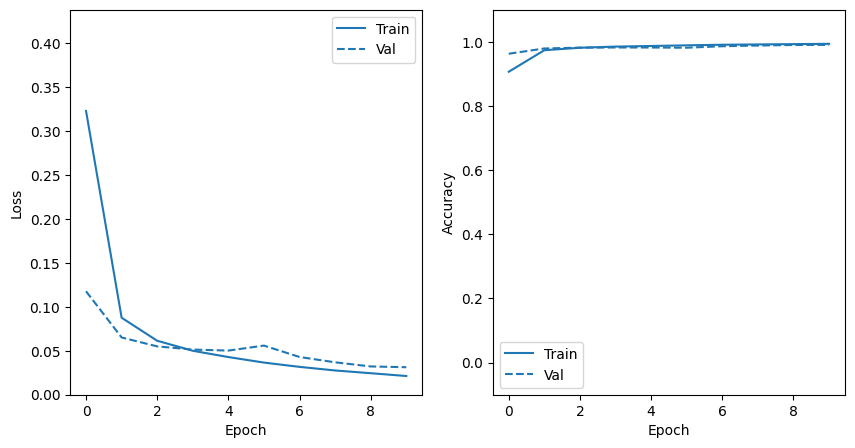

In [86]:
plot_metrics(model11_history)

In [87]:
set_seeds()
model11 = Sequential()
model11.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model11.add(MaxPool2D((2, 2)))
model11.add(Conv2D(32, (3,3), activation='relu')) 
model11.add(MaxPool2D((2,2)))
model11.add(Conv2D(32, (3,3), activation='relu'))
model11.add(MaxPool2D((1,1)))
model11.add(Flatten())
model11.add(Dense(n_classes, activation='softmax')) 
model11.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model11_history = model11.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7976 - loss: 0.7007 - val_accuracy: 0.9628 - val_loss: 0.1176
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9712 - loss: 0.0968 - val_accuracy: 0.9792 - val_loss: 0.0651
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9811 - loss: 0.0639 - val_accuracy: 0.9818 - val_loss: 0.0549
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9850 - loss: 0.0518 - val_accuracy: 0.9823 - val_loss: 0.0513
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9869 - loss: 0.0447 - val_accuracy: 0.9822 - val_loss: 0.0502
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9888 - loss: 0.0382 - val_accuracy: 0.9816 - val_loss: 0.0559
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9910 - loss: 0.0333 - val_accuracy: 0.9862 - val_loss: 0.0429
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0290 - val_accuracy: 0.

In [88]:
loss, acc = model11.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.990


In [117]:
err = print_res(model11)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [118]:
err

0

*Here, the accuracy decreased as well as the models complexity.*

*Model 11 parameters:*
- *Model Complexity (Paramereters) = 22410*
- *Accuracy: 0.99*
- *Test error in first 100 images: 0*

*In the last experiment I ran, I tried to add same padding. I added it to the second convolution layer, because I assumed previously that the this layer might 'eat' to many of the corner pixels. Therefore, setting the padding, the shape would stay stable and all incomming pixels are taken into account.*

In [115]:
set_seeds()
model12 = Sequential()
model12.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model12.add(MaxPool2D((2, 2)))
model12.add(Conv2D(32, (3,3), activation='relu', padding='same') )
model12.add(MaxPool2D((2,2)))
model12.add(Conv2D(32, (3,3), activation='relu'))
model12.add(MaxPool2D((1,1)))
model12.add(Flatten())
model12.add(Dense(n_classes, activation='softmax')) 
model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model12.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,474 (165.91 KB)

 Trainable params: 42,474 (165.91 KB)

 Non-trainable params: 0 (0.00 B)

*I added padding to the second convolution layer. Hence, the ouput shape is the same like in the first pooling layer. The cnn 'eats' pixels only in the first and third conv layer, resulting in overall 8 'eaten' corner pixels.*

In [116]:
model12_history = model12.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8206 - loss: 0.5966 - val_accuracy: 0.9681 - val_loss: 0.0987
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9768 - loss: 0.0783 - val_accuracy: 0.9783 - val_loss: 0.0672
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9839 - loss: 0.0534 - val_accuracy: 0.9824 - val_loss: 0.0530
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9877 - loss: 0.0420 - val_accuracy: 0.9848 - val_loss: 0.0458
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9898 - loss: 0.0343 - val_accuracy: 0.9871 - val_loss: 0.0375
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9917 - loss: 0.0292 - val_accuracy: 0.9883 - val_loss: 0.0371
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9926 - loss: 0.0255 - val_accuracy: 0.9889 - val_loss: 0.0337
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9932 - loss: 0.0225 - val_accuracy: 0.

*I don't know why the early stopping callback restored the weights of epoch 1, since the best val_accuracy was found in epoch 10. So I ran the training again. After I plotted the training history.*

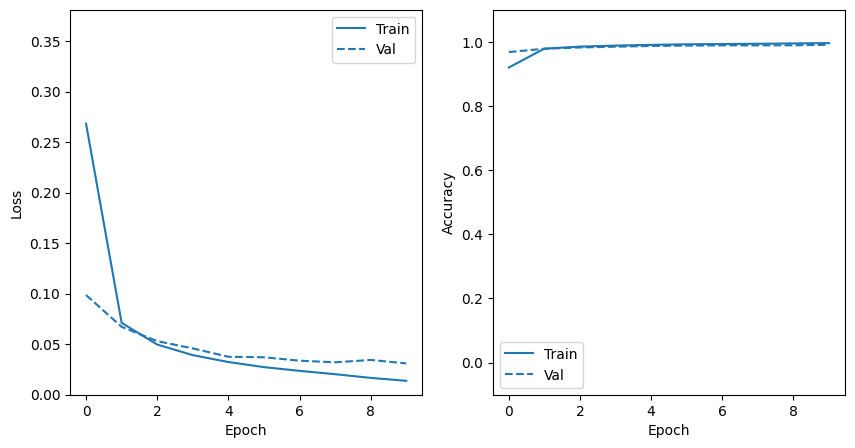

In [119]:
plot_metrics(model12_history)

In [120]:
set_seeds()
model12 = Sequential()
model12.add(Conv2D(32, (9,9), activation='relu',input_shape=in_shape))
model12.add(MaxPool2D((2, 2)))
model12.add(Conv2D(32, (3,3), activation='relu', padding='same') )
model12.add(MaxPool2D((2,2)))
model12.add(Conv2D(32, (3,3), activation='relu'))
model12.add(MaxPool2D((1,1)))
model12.add(Flatten())
model12.add(Dense(n_classes, activation='softmax')) 
model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model12_history = model12.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

/media/home/ngundermann/workspace/DML_notebooks/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8005 - loss: 0.6695 - val_accuracy: 0.9647 - val_loss: 0.1063
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9736 - loss: 0.0884 - val_accuracy: 0.9802 - val_loss: 0.0610
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9818 - loss: 0.0570 - val_accuracy: 0.9818 - val_loss: 0.0553
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9860 - loss: 0.0443 - val_accuracy: 0.9829 - val_loss: 0.0517
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9888 - loss: 0.0367 - val_accuracy: 0.9853 - val_loss: 0.0449
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9904 - loss: 0.0309 - val_accuracy: 0.9875 - val_loss: 0.0388
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9919 - loss: 0.0271 - val_accuracy: 0.9883 - val_loss: 0.0377
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9927 - loss: 0.0239 - val_accuracy: 0.

In [121]:
loss, acc = model12.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.988


In [122]:
err = print_res(model12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [123]:
err

1

*Unfotunately, this was not good for neither, accuracy and models complexity. The accuracy shrank to 0.988 and the number of parameters rise to 42474*

*Model 11 parameters:*
- *Model Complexity (Paramereters) = 42474*
- *Accuracy: 0.988*
- *Test error in first 100 images: 1*

*Some words about abount learning convergence according to the loss curves: All of them converged very fast after 2 epochs. The first learning step was quite big in each experiments compared to the other learning steps. However, they converged at different losses, since the accuracy was different (, which is not guaranteed, but at least an indicator for a smaller of bigger loss.)*

*Since the loss curves are quite similar, I neglected to describe them for each experiment in detail. Maybe, there is a setting I missed at which I could have seen an interesting difference?*

*In the end model 10 was the best one I found.*

*Model 10 parameters:*
- *Model Complexity (Paramereters) = 35030*
- *Accuracy: 0.993*
- *Test error in first 100 images: 0*